In [1]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from torch.distributions import Uniform
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, OneCycleLR
from torch_poly_lr_decay import PolynomialLRDecay

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor, StochasticWeightAveraging
from pytorch_lightning.loggers import WandbLogger

import wandb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

PATH_DATASETS = "."
AVAIL_GPUS = min(1, torch.cuda.device_count())
# BATCH_SIZE = 1024 if AVAIL_GPUS else 64

In [2]:
pl.seed_everything(8407)

Global seed set to 8407


8407

In [3]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Create Dataset

In [4]:
def f(x):
    return np.sin(x / 10) + (x / 50) ** 2

In [5]:
x = np.random.rand(100) * 100
y = f(x) + np.random.randn(100) / 2

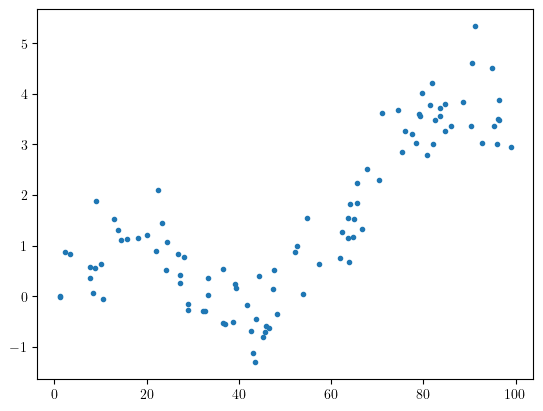

In [6]:
plt.plot(x,y, '.')
plt.show()

In [7]:
class RegData(Dataset):
    def __init__(self, N):
        x = torch.rand(N) * 100
        y = f(x) + torch.randn(N) / 2
        
        self.x = x.reshape(-1,1)
        self.y = y.reshape(-1,1)
    
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [8]:
ds = RegData(100)

In [9]:
ds[0]

(tensor([71.2459]), tensor([3.4375]))

In [10]:
# def cov(X):
#     n = X.shape[1]
#     mu = torch.mean(X, 0)
#     Y = X - mu
#     return torch.mm(Y, Y.T) / (n-1)

In [11]:
def decov(h):
    C = torch.cov(h)
    C_diag = torch.diag(C, 0)
    return 0.5 * (torch.norm(C, 'fro')**2 - torch.norm(C_diag, 2)**2)

In [12]:
a = torch.tensor([[1,2],[3,4]], dtype=torch.float32)
decov(a)

tensor(0.2500)

In [13]:
b = torch.rand((2,2))
decov(b)

tensor(0.0032)

## Simple MLP

In [14]:
class SimpleMLP(pl.LightningModule):
    def __init__(self, hparams=None):
        super().__init__()
        
        self.epochs = hparams['epochs']
        self.N = hparams['N']
        self.learning_rate = hparams['learning_rate']
        self.batch_size = hparams['batch_size']
        self.hidden_nodes = hparams['hidden_nodes']
        
        self.fc_init = nn.Sequential(
            nn.Linear(1, self.hidden_nodes),
            nn.Sigmoid()
        )
        
        self.fc_mid = nn.Sequential(
            nn.Linear(self.hidden_nodes, self.hidden_nodes),
            nn.ReLU(inplace=True),
            nn.Linear(self.hidden_nodes, self.hidden_nodes),
            nn.ReLU(inplace=True),
            nn.Linear(self.hidden_nodes, self.hidden_nodes),
            nn.ReLU(inplace=True),
        )
        
        self.fc_final = nn.Linear(self.hidden_nodes, 1)
        
        self.save_hyperparameters(hparams)
        
    def forward(self, x):
        x = self.fc_init(x)
        x = self.fc_mid(x)
        return self.fc_final(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        
        y_hat = self(x)
        
        loss = F.mse_loss(y,y_hat)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
                
        h0 = self.fc_init(x)
        self.log('decov_0', decov(h0))
        
        h1 = self.fc_mid(h0)
        self.log('decov_1', decov(h1))
        
        y_hat = self.fc_final(h1)
        
        loss = F.mse_loss(y,y_hat)
        
        self.log('val_loss', loss)
        
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(
            self.parameters(),
            lr=self.learning_rate,
        )
        
        return optimizer
        
    def prepare_data(self):
        self.ds = RegData(self.N)
    
    def setup(self, stage=None):
        N_train = self.N // 10 * 7
        N_val = self.N - N_train
        if stage == "fit" or stage is None:
            self.ds_train, self.ds_val = random_split(self.ds, [N_train, N_val])
        if stage == "test" or stage is None:
            _, self.ds_test = random_split(self.ds, [N_train, N_val])
            
    def train_dataloader(self):
        return DataLoader(self.ds_train, batch_size=self.batch_size)
    
    def val_dataloader(self):
        return DataLoader(self.ds_val, batch_size=self.batch_size)
    
    def test_dataloader(self):
        return DataLoader(self.ds_test, batch_size=self.batch_size)

In [15]:
pl.seed_everything(8407)

Global seed set to 8407


8407

In [16]:
hparams = {
    "N": 1000,
    "learning_rate": 1e-3,
    "batch_size": 50,
    "epochs": 1000,
    "hidden_nodes": 64
}

In [17]:
model = SimpleMLP(
    hparams=hparams
)

wandb_logger = WandbLogger(
    project='DeCov'
)

trainer = Trainer(
    logger=wandb_logger,
    max_epochs=hparams["epochs"],
    gpus=AVAIL_GPUS,
    enable_progress_bar=False,
#     callbacks=[
#         LearningRateMonitor(logging_interval="step")
#     ]
)

wandb: Currently logged in as: axect. Use `wandb login --relogin` to force relogin


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [18]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | fc_init  | Sequential | 128   
1 | fc_mid   | Sequential | 12.5 K
2 | fc_final | Linear     | 65    
----------------------------------------
12.7 K    Trainable params
0         Non-trainable params
12.7 K    Total params
0.051     Total estimated model params size (MB)


In [19]:
wandb.finish()

decov_0,█▃▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
decov_1,▇▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇▇▇▇▇████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
decov_0,40.26703
decov_1,157.51596
epoch,999
trainer/global_step,13999
val_loss,0.2582


## Test

In [20]:
ds = RegData(N=500)
dl = DataLoader(ds, batch_size=hparams['batch_size'])

In [21]:
model.eval()

SimpleMLP(
  (fc_init): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (fc_mid): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU(inplace=True)
  )
  (fc_final): Linear(in_features=64, out_features=1, bias=True)
)

In [22]:
domain1 = torch.tensor([])
output1 = torch.tensor([])
y_true1 = torch.tensor([])
for data in dl:
    x, y = data
    y_hat = model(x)
    domain1 = torch.cat([domain1, x])
    output1 = torch.cat([output1, y_hat])
    y_true1 = torch.cat([y_true1, y])

In [23]:
domain1 = domain1.reshape(-1).detach().numpy()
output1 = output1.reshape(-1).detach().numpy()
y_true1 = y_true1.reshape(-1).detach().numpy()

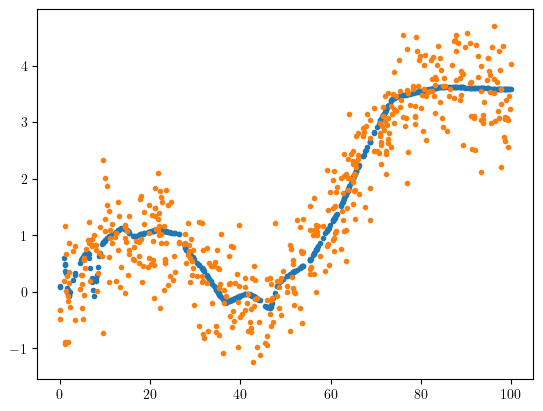

In [24]:
plt.plot(domain1, output1, '.')
plt.plot(domain1, y_true1, '.')
plt.show()

## With DeCov

In [25]:
class DeCovMLP(pl.LightningModule):
    def __init__(self, hparams=None):
        super().__init__()
        
        self.epochs = hparams['epochs']
        self.N = hparams['N']
        self.learning_rate = hparams['learning_rate']
        self.batch_size = hparams['batch_size']
        self.hidden_nodes = hparams['hidden_nodes']
        
        self.fc_init = nn.Sequential(
            nn.Linear(1, self.hidden_nodes),
            nn.Sigmoid()
        )
        
        self.fc_mid = nn.Sequential(
            nn.Linear(self.hidden_nodes, self.hidden_nodes),
            nn.ReLU(inplace=True),
            nn.Linear(self.hidden_nodes, self.hidden_nodes),
            nn.ReLU(inplace=True),
            nn.Linear(self.hidden_nodes, self.hidden_nodes),
            nn.ReLU(inplace=True),
        )
        
        self.fc_final = nn.Linear(self.hidden_nodes, 1)
        
        self.save_hyperparameters(hparams)
        
    def forward(self, x):
        x = self.fc_init(x)
        x = self.fc_mid(x)
        return self.fc_final(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        
        h0 = self.fc_init(x)
        loss_0 = decov(h0)
#         self.log('decov_0', loss_0)
        
        h1 = self.fc_mid(h0)
        loss_1 = decov(h1)
#         self.log('decov_1', loss_1)
        
        y_hat = self.fc_final(h1)
        
        loss = F.mse_loss(y,y_hat) + loss_0 + loss_1
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
                
        h0 = self.fc_init(x)
        loss_0 = decov(h0)
        self.log('decov_0', loss_0)
        
        h1 = self.fc_mid(h0)
        loss_1 = decov(h1)
        self.log('decov_1', loss_1)
        
        y_hat = self.fc_final(h1)
        
        loss = F.mse_loss(y,y_hat) + loss_0 + loss_1
        
        self.log('val_loss', loss)
        
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(
            self.parameters(),
            lr=self.learning_rate,
        )
        
        return optimizer
        
    def prepare_data(self):
        self.ds = RegData(self.N)
    
    def setup(self, stage=None):
        N_train = self.N // 10 * 7
        N_val = self.N - N_train
        if stage == "fit" or stage is None:
            self.ds_train, self.ds_val = random_split(self.ds, [N_train, N_val])
        if stage == "test" or stage is None:
            _, self.ds_test = random_split(self.ds, [N_train, N_val])
            
    def train_dataloader(self):
        return DataLoader(self.ds_train, batch_size=self.batch_size)
    
    def val_dataloader(self):
        return DataLoader(self.ds_val, batch_size=self.batch_size)
    
    def test_dataloader(self):
        return DataLoader(self.ds_test, batch_size=self.batch_size)

In [26]:
pl.seed_everything(8407)

Global seed set to 8407


8407

In [27]:
model2 = DeCovMLP(
    hparams=hparams
)

wandb_logger = WandbLogger(
    project='DeCov'
)

trainer = Trainer(
    logger=wandb_logger,
    max_epochs=hparams["epochs"],
    gpus=AVAIL_GPUS,
    enable_progress_bar=False,
#     callbacks=[
#         LearningRateMonitor(logging_interval="step")
#     ]
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [28]:
trainer.fit(model2)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | fc_init  | Sequential | 128   
1 | fc_mid   | Sequential | 12.5 K
2 | fc_final | Linear     | 65    
----------------------------------------
12.7 K    Trainable params
0         Non-trainable params
12.7 K    Total params
0.051     Total estimated model params size (MB)


In [29]:
wandb.finish()

decov_0,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
decov_1,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
decov_0,0.00047
decov_1,0.00125
epoch,999
trainer/global_step,13999
val_loss,0.24523


In [30]:
model2.eval()

DeCovMLP(
  (fc_init): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (fc_mid): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU(inplace=True)
  )
  (fc_final): Linear(in_features=64, out_features=1, bias=True)
)

In [31]:
domain2 = torch.tensor([])
output2 = torch.tensor([])
y_true2 = torch.tensor([])
for data in dl:
    x, y = data
    y_hat = model2(x)
    domain2 = torch.cat([domain2, x])
    output2 = torch.cat([output2, y_hat])
    y_true2 = torch.cat([y_true2, y])
    
domain2 = domain2.reshape(-1).detach().numpy()
output2 = output2.reshape(-1).detach().numpy()
y_true2 = y_true2.reshape(-1).detach().numpy()

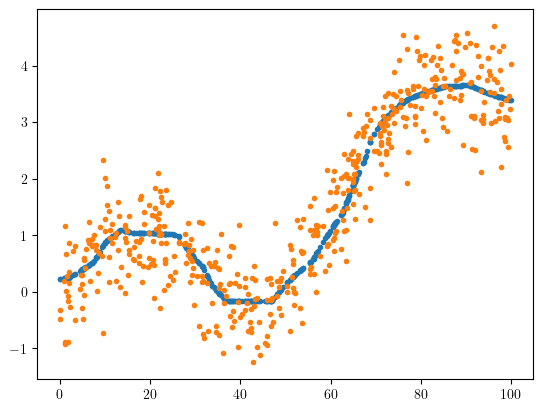

In [32]:
plt.plot(domain2, output2, '.')
plt.plot(domain2, y_true2, '.')
plt.show()

## Test SimpleMLP vs DeCovMLP

In [33]:
x = np.linspace(0, 100, 1000)
y = f(x) + np.random.randn(len(x)) / 2
y_true = f(x)

x_torch = torch.tensor(x, dtype=torch.float).reshape(-1,1)
B = hparams['batch_size']

domain = torch.tensor([])
out_simple = torch.tensor([])
out_decov  = torch.tensor([])
for i in range(len(x) // B):
    x_i = x_torch[i*B:(i+1)*(B)]
    y_hat1 = model(x_i)
    y_hat2 = model2(x_i)
    out_simple = torch.concat([out_simple, y_hat1])
    out_decov = torch.concat([out_decov, y_hat2])
    
out_simple = out_simple.reshape(-1).detach().numpy()
out_decov = out_decov.reshape(-1).detach().numpy()

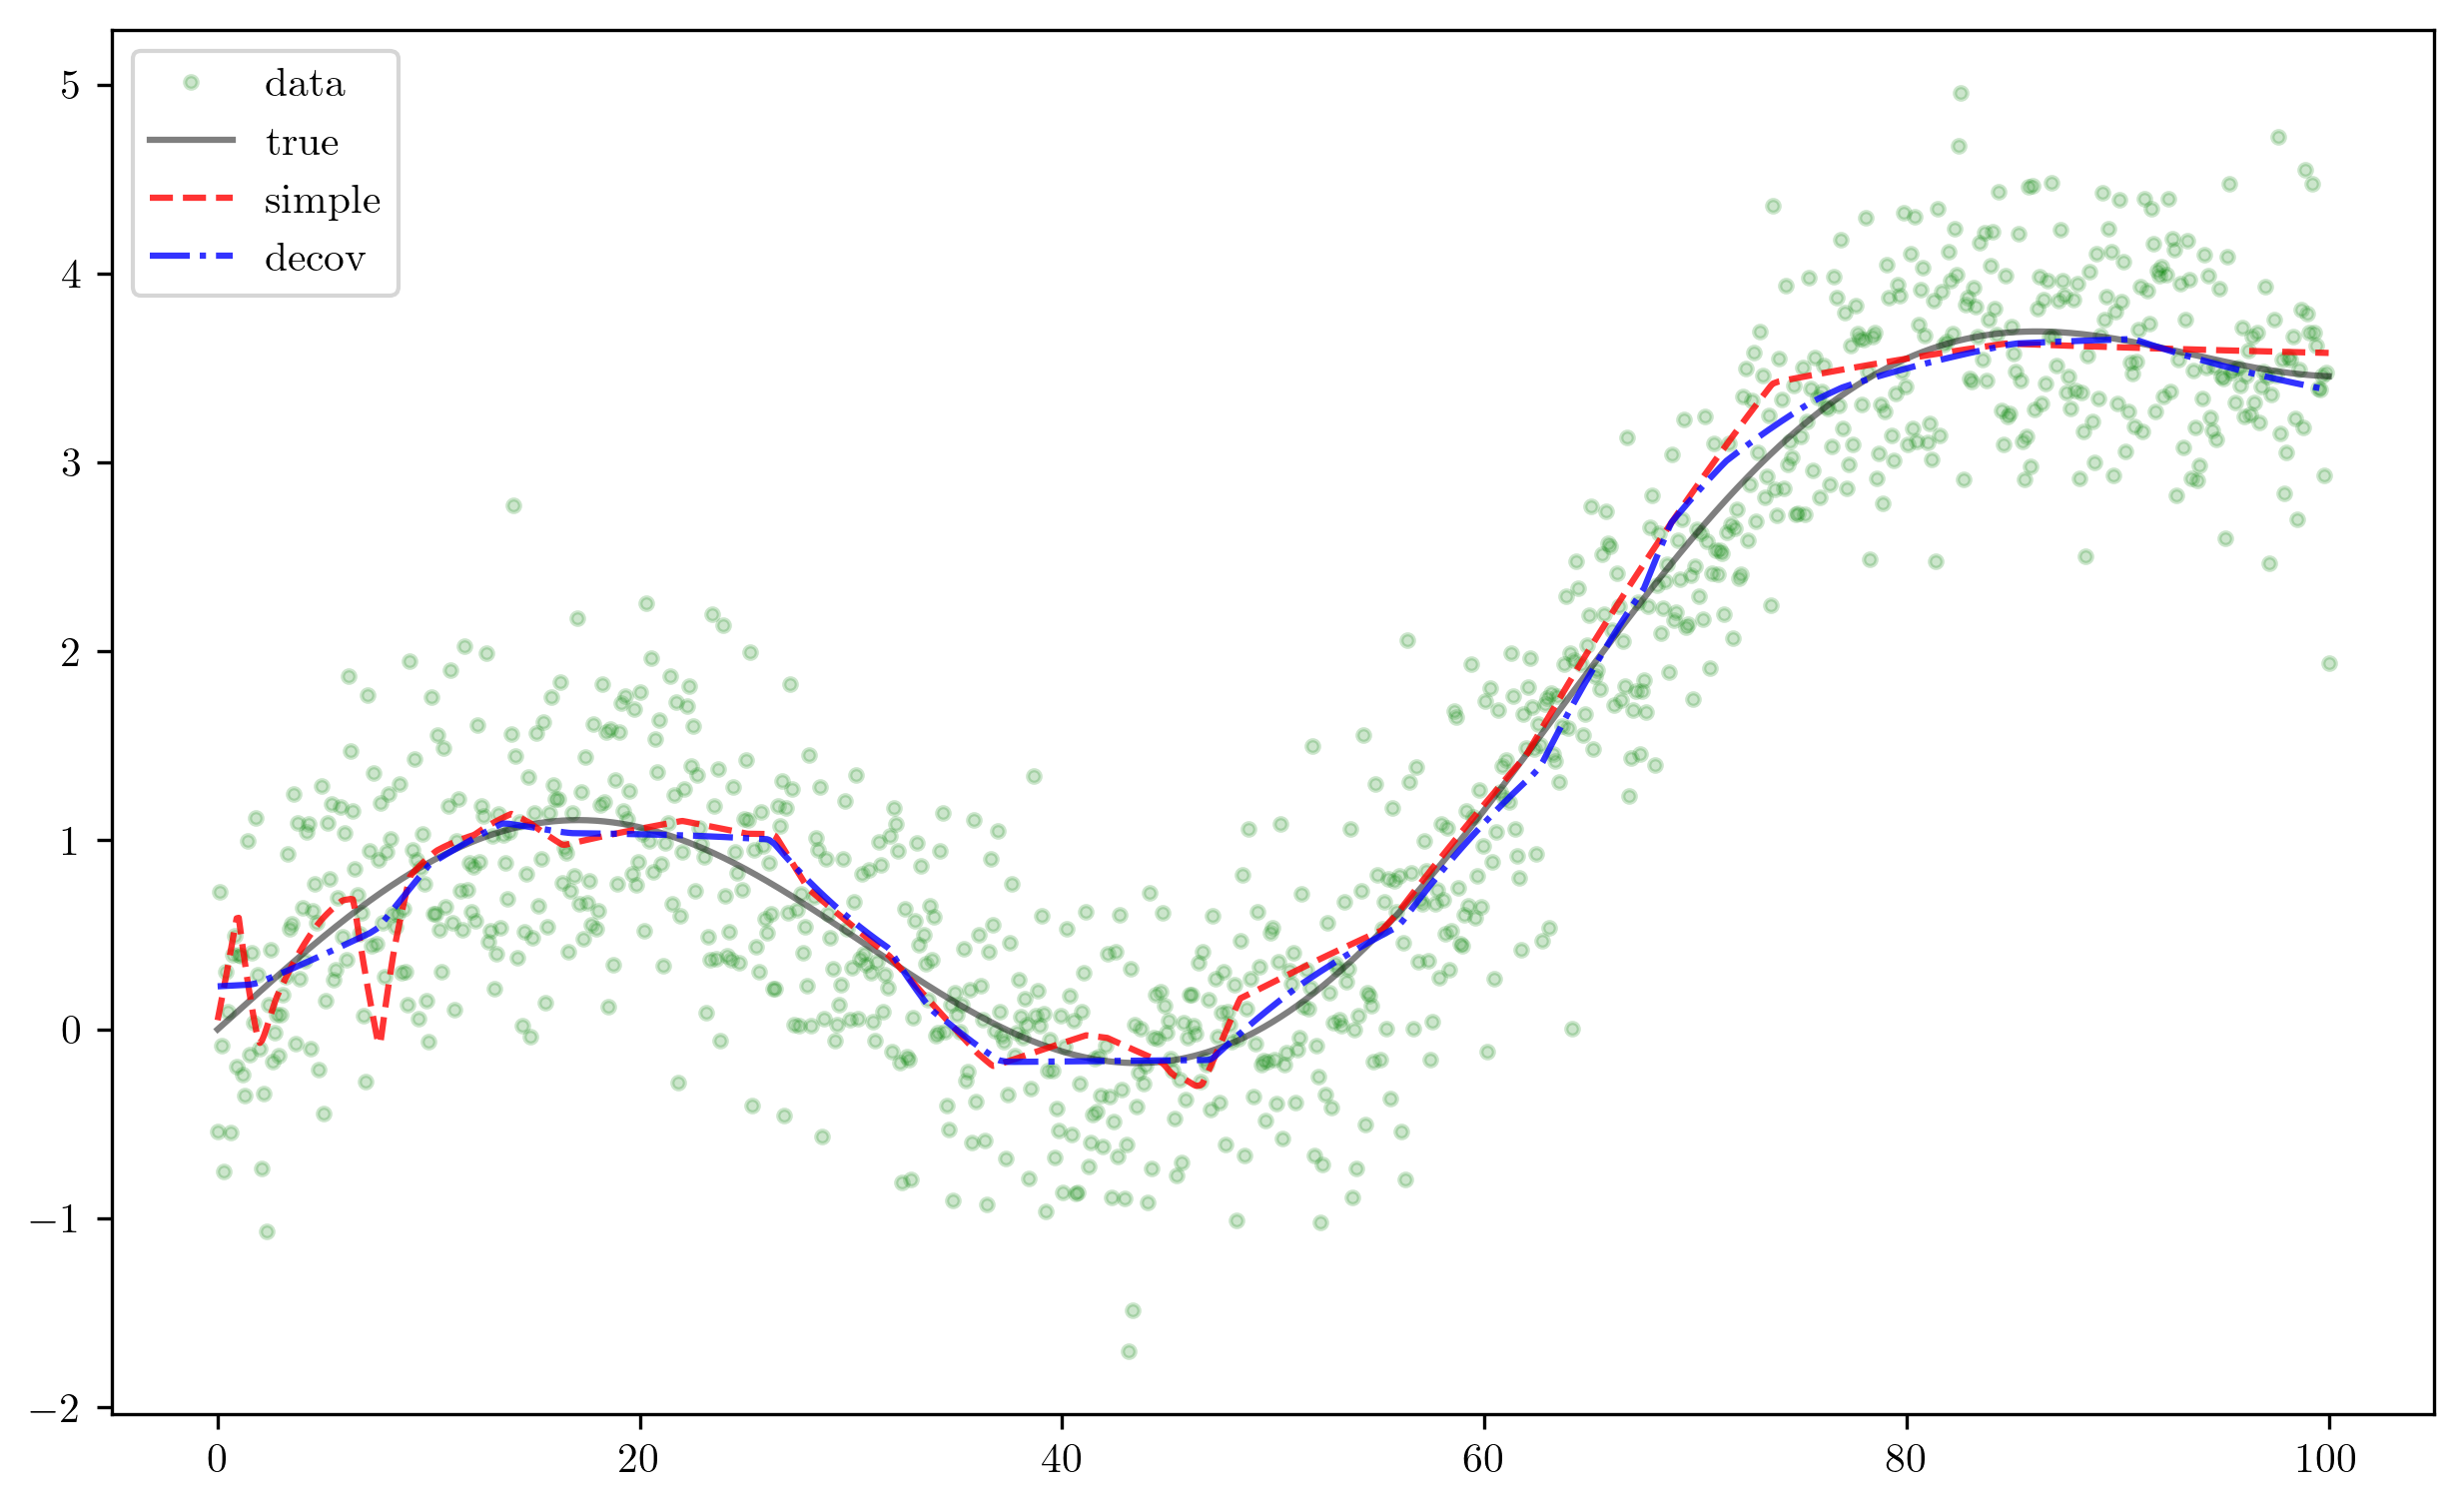

In [35]:
plt.figure(figsize=(10,6), dpi=300)
plt.plot(x, y, 'g.', alpha=0.2, label='data')
plt.plot(x, y_true, 'k', alpha=0.5, label='true')
plt.plot(x, out_simple, 'r--', alpha=0.8, label='simple')
plt.plot(x, out_decov, 'b-.', alpha=0.8, label='decov')
plt.legend()
plt.show()